# Lights 

> Defines some light schedules for building circadian models

In [ ]:
#| default_exp lights

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export 

from matplotlib.pyplot import step
import numpy as np
from numpy.core.fromnumeric import repeat
import pylab as plt

In [ ]:
#| export

class Light:

    def __init__(self, func, 
                 duration: float,
                 start_time: float = 0.0, 
                 default_value=0.0):
        self._func = np.vectorize(func)
        self.default_value = default_value
        self.start_time = start_time
        self.duration = duration

    @property
    def end_time(self):
        return self.start_time+self.duration

    def __call__(self, t: float):
        return self._func(t)
        if (t > self.start_time) and (t <= self.end_time):
            return self._func(t)
        else:
            return self.default_value

    def __add__(self, light_obj):
        switch_time = self.end_time
        def light_func_new(t): return np.piecewise(t, [t <= switch_time, t >= switch_time],
                                                   [
            self._func, lambda t: light_obj._func(t-switch_time)])

        start_time_new = min(self.start_time, light_obj.start_time)
        duration_new = light_obj.duration + self.duration

        return Light(light_func_new, duration_new, start_time=start_time_new)
    
    def numpy(self, dt: float = 0.10):
        t = np.arange(self.start_time, self.end_time, dt)
        vals = self.__call__(t)
        return (t,vals)

    def plot(self, ax=None, showplot=True, *args, **kwargs):
        t = np.linspace(self.start_time, self.end_time, 10000)
        vals = self.__call__(t)
        if ax is None:
            plt.figure()
            ax = plt.gca()

        ax.plot(t, vals, *args, **kwargs)
        if showplot:
            plt.show()
        return ax



## Some Common Schedules


In [ ]:
#| export

def make_pulse(t, tstart, tend, steep: float = 30.0):
    return 0.5*np.tanh(steep*(t-tstart))-0.5*np.tanh(steep*(t-tend))

def get_pulse(t: float,
              t1: float,
              t2: float,
              repeat=False,
              Intensity: float = 150.0):

    if repeat:
        t = np.fmod(t, 24.0)
    if t < 0.0:
        t += 24.0

    light_value = Intensity*make_pulse(t, t1, t2)
    return np.abs(light_value)


In [ ]:
#| export

def RegularLight(t, Intensity=150.0, wakeUp=8.0, workday=16.0, steep: float = 30.0):
    """Define a basic light schedule with a given intensity of the light, wakeup time and length of the active period (non-sleeping)
    This schedule will automatically repeat on a daily basis, so each day will be the same.....
    """

    s = np.fmod(t, 24.0)
    if (s < 0):
        s += 24.0
    light_val = Intensity * make_pulse(s, wakeUp, workday+wakeUp, steep=steep)
    if wakeUp+workday >= 24.0:
        light_val += Intensity * \
            make_pulse(s, 0.0, workday+wakeUp-24.0, steep=steep)

    return light_val


def ShiftWorkLight(t: float,
                   Intensity: float = 150.0,
                   dayson: int = 5,
                   daysoff: int = 2):
    """
    Simulate a night shift worker. Assume they are working a night shift for dayson number of days followed by daysoff normal days where they revert to a normal schedule
    ShiftWorkLight(t, dayson=5, daysoff=2)
    """

    t = np.fmod(t, (dayson+daysoff)*24)  # make it repeat
    if (t <= 24*dayson):
        return(RegularLight(t, Intensity=Intensity, wakeUp=16.0, workday=16.0))

    else:
        return(RegularLight(t, Intensity=Intensity, wakeUp=9.0, workday=16.0))


def ShiftWorkerThreeTwelves(t, Intensity=150.0, pos=False):
    """
    Simulate a worker who does three 12 hour night shifts in a row followed 
    by four days off. 
    Works 8am-8pm for three days and then shifts to a diurnal schedule for 
    four days
    pos controls if they sleep right after the shift or if they wait and sleep
    before the next shift
    """

    t = np.fmod(t, 7*24)  # make it repeat weekly
    if (t <= 24*3):
        if not pos:
            return(RegularLight(t, Intensity=Intensity, wakeUp=19.0, workday=16.0))
        else:
            def f(t): return RegularLight(t, 
                                          Intensity=Intensity,
                                          wakeUp=19.0,
                                          workday=12.0)+RegularLight(t,
                                                                     Intensity=Intensity,
                                                                     wakeUp=7.0,
                                                                     duration=4.0)
            return f
    else:
        return(RegularLight(t, Intensity=Intensity, wakeUp=7.0, workday=16.0))


def SocialJetLag(t, weekdayWake=7.0, weekdayBed=24.0, weekendWake=11.0, weekendBed=2.0):
    """Simulate a social jetlag schedule. """

    t = np.fmod(t, (7)*24)  # make it repeat each week

    if (t <= 24*5):
        # Monday through thursday
        duration = np.fmod(weekdayBed-weekdayWake, 24.0)
        if duration < 0.0:
            duration += 24.0
        return(RegularLight(t, 
                            Intensity=150.0, 
                            wakeUp=weekdayWake,
                            workday=duration)
               )
    if (t > 24*5 and t <= 24*7):
        # Friday, stay up late
        duration = np.fmod(weekendBed-weekendWake, 24.0)
        if duration < 0.0:
            duration += 24.0
        return(RegularLight(t, Intensity=250.0, wakeUp=weekendWake, workday=duration))


def SlamShift(t, shift=8.0, Intensity=150.0, beforeDays=10):
    """Simulate a sudden shift in the light schedule"""

    if (t <= 24*beforeDays):
        return(RegularLight(t, Intensity, wakeUp=8.0, workday=16.0))
    else:
        newVal = np.fmod(8.0+shift, 24.0)
        if (newVal < 0):
            newVal += 24.0
        return(RegularLight(t, Intensity, wakeUp=newVal, workday=16.0))
    


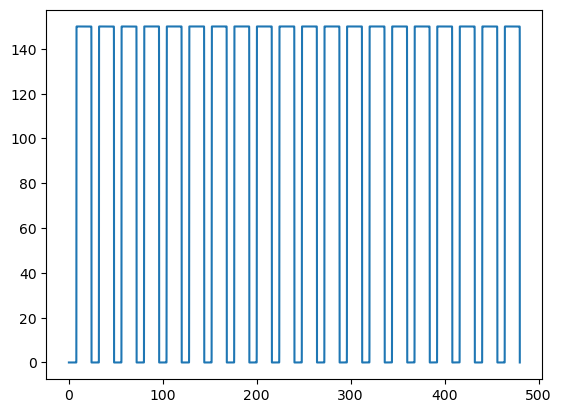

In [ ]:
LS=Light(lambda t: SlamShift(t, beforeDays=3.0), duration=3*24.0)
LR = Light(lambda t: RegularLight(t), duration=10*24.0)
LS = Light(lambda t: get_pulse(
    t, 20.00, 7.00, repeat=True), duration=72.0)
L3 = LR+LR
L3.plot();


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()